In [1]:
pip install -U googlemaps

  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40712 sha256=cfaf83ad5131fca7377f3a42c39a044cfd5412cd49e8a925a225cd2d2279516d
  Stored in directory: /root/.cache/pip/wheels/17/f8/79/999d5d37118fd35d7219ef57933eb9d09886c4c4503a800f84
Successfully built googlemaps


### Comparing Haversine Distance vs Google Maps Distance Matrix API
In order to get a better travel distance to correlate with the `fare_amount` and other important categorical variables, i use the coordinates in a sample of `NYCTaxiFares` dataset to calculate using the Google Maps Distance Matrix API one possible route that match the pickup and dropout coordinates. This is done in COLAB. As the graphics depicts the use of the haversine distance seems to be a good option. 

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

df = pd.read_csv("NYCTaxiFares.csv")

def haversine_distance(df, lat1, lon1, lat2, lon2):

    # average radius of the Earth in (km)
    r = 6371

    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2] - df[lat1])
    delta_lambda = np.radians(df[lon2] - df[lon1])

    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)

    return d

# append a 'dist_km' new feature in the dataframe
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')


df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# correcting NYC april eastern hour
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

# extracting specific datetime information
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12, 'am', 'pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

# set a list of categorical variables
cat_cols = ['Hour', 'AMorPM', 'Weekday']

# transform to pandas categorical variables
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

df.drop('pickup_datetime', inplace=True, axis=1)
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [22]:
from google.colab import userdata
import googlemaps

api_key = userdata.get('MATRIX_API_KEY')
gmaps = googlemaps.Client(key=api_key)

def calculate_transit_distance(gmaps, df, origin_lat, origin_lon, dest_lat, dest_lon):
    distances = []
    for i in range(len(df)):
        try:
            origins = (df[origin_lat].iloc[i], df[origin_lon].iloc[i])
            destinations = (df[dest_lat].iloc[i], df[dest_lon].iloc[i])
            result = gmaps.distance_matrix(origins, destinations, mode='driving')
            distance = result['rows'][0]['elements'][0]['distance']['value'] / 1000  # Convert to km
            distances.append(distance)
        except Exception as e:
            print(f"Error for index {i}: {e}")
            distances.append(None)
    return distances

# Test the function with 50 records
test_df = df.head(500).copy()
test_df['transit_distance_km'] = calculate_transit_distance(gmaps, test_df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   fare_amount          500 non-null    float64            
 1   fare_class           500 non-null    int64              
 2   pickup_longitude     500 non-null    float64            
 3   pickup_latitude      500 non-null    float64            
 4   dropoff_longitude    500 non-null    float64            
 5   dropoff_latitude     500 non-null    float64            
 6   passenger_count      500 non-null    int64              
 7   dist_km              500 non-null    float64            
 8   EDTdate              500 non-null    datetime64[ns, UTC]
 9   Hour                 500 non-null    category           
 10  AMorPM               500 non-null    category           
 11  Weekday              500 non-null    category           
 12  transit_distance_km  5

In [12]:
test_df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday,transit_distance_km
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon,2.533
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat,2.230
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat,4.635
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun,2.089
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri,11.139


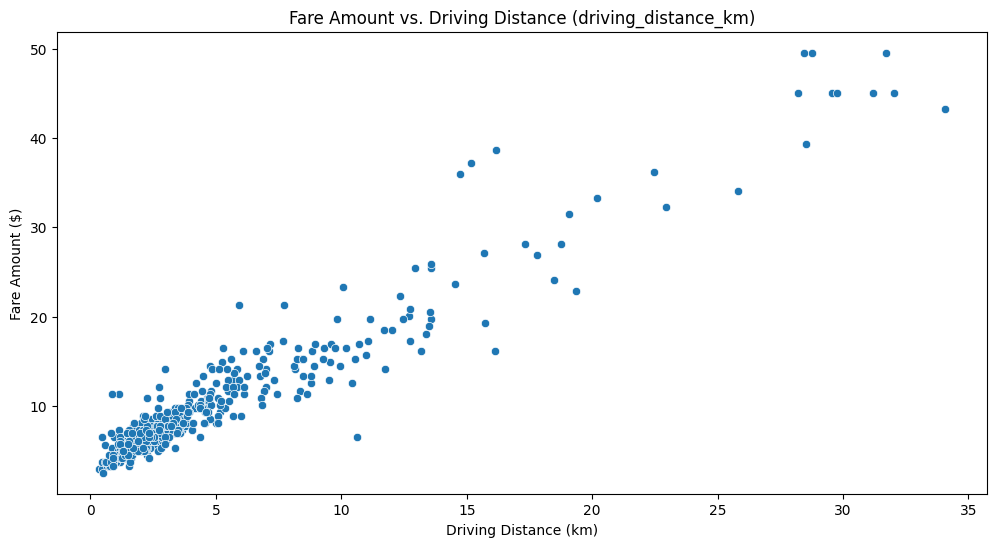

In [23]:
# Scatter plot to show the relationship between driving_distance_km and fare_amount
plt.figure(figsize=(12, 6))
sns.scatterplot(x='transit_distance_km', y='fare_amount', data=test_df)
plt.title('Fare Amount vs. Driving Distance (driving_distance_km)')
plt.xlabel('Driving Distance (km)')
plt.ylabel('Fare Amount ($)')
plt.show()

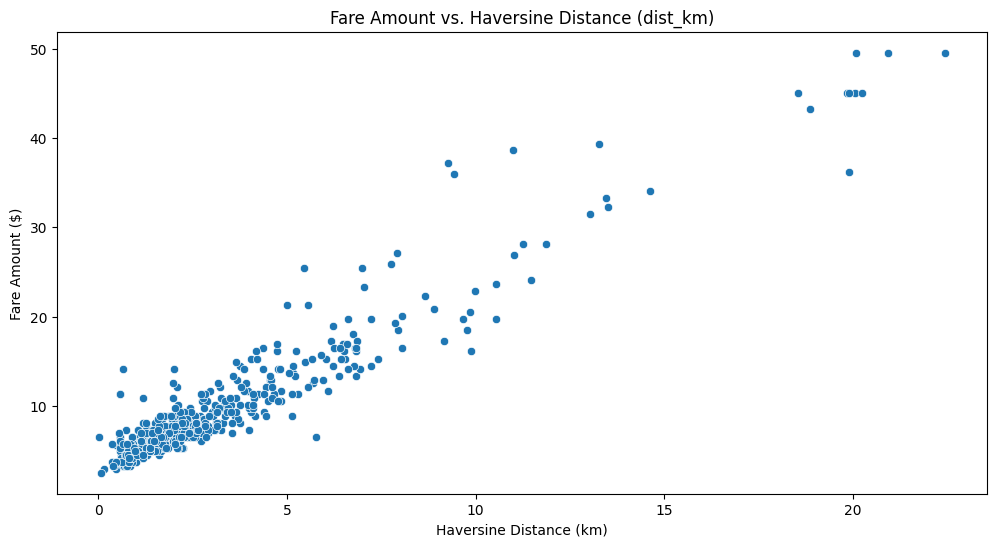

In [25]:
# Scatter plot to show the relationship between dist_km and fare_amount
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dist_km', y='fare_amount', data=test_df)
plt.title('Fare Amount vs. Haversine Distance (dist_km)')
plt.xlabel('Haversine Distance (km)')
plt.ylabel('Fare Amount ($)')
plt.show()

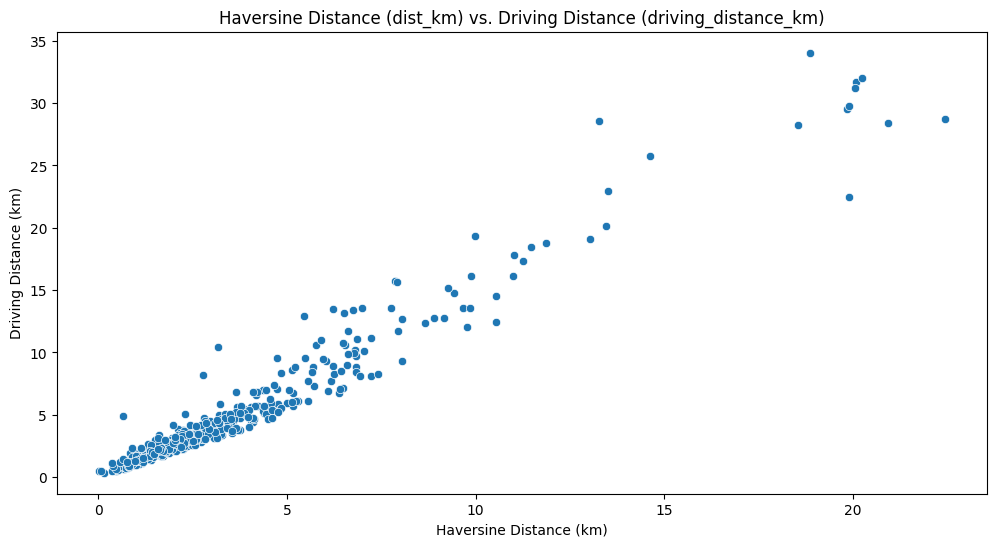

In [26]:
# Scatter plot to show the relationship between dist_km and driving_distance_km
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dist_km', y='transit_distance_km', data=test_df)
plt.title('Haversine Distance (dist_km) vs. Driving Distance (driving_distance_km)')
plt.xlabel('Haversine Distance (km)')
plt.ylabel('Driving Distance (km)')
plt.show()

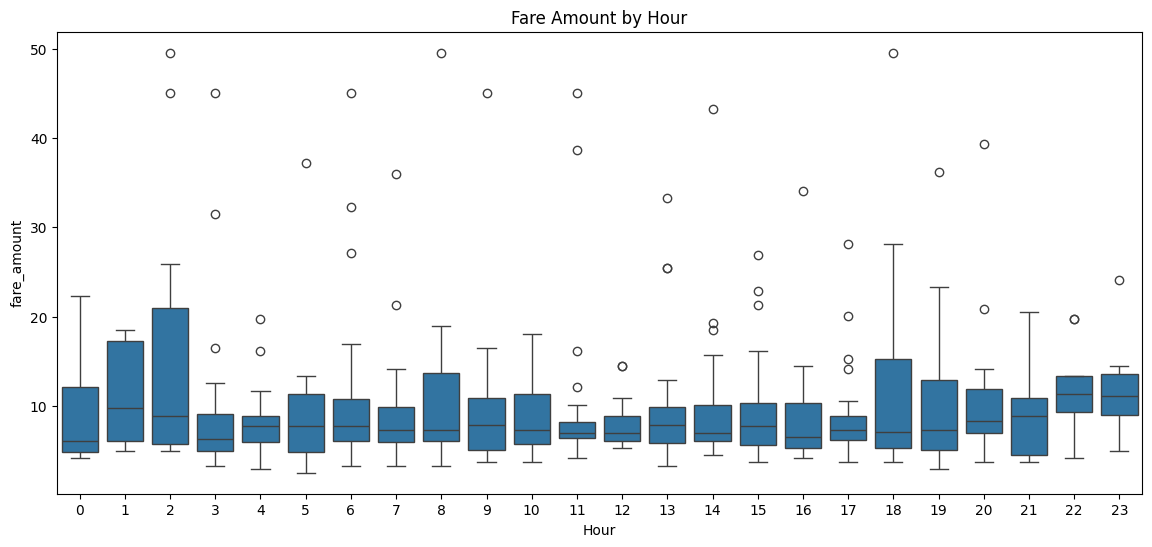

In [27]:
# Boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(x='Hour', y='fare_amount', data=test_df)
plt.title('Fare Amount by Hour')
plt.show()

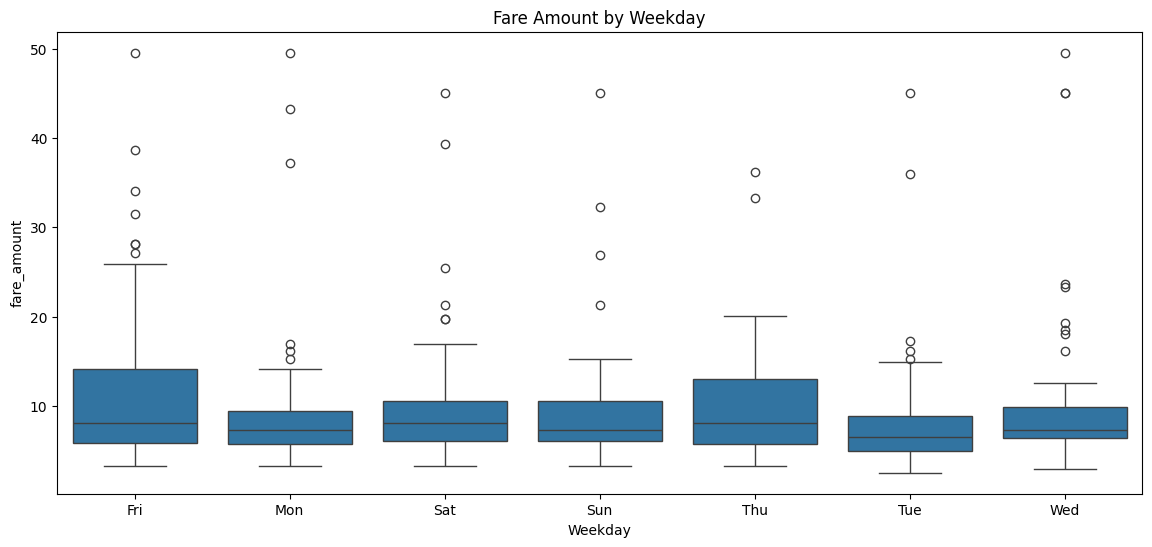

In [28]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Weekday', y='fare_amount', data=test_df)
plt.title('Fare Amount by Weekday')
plt.show()

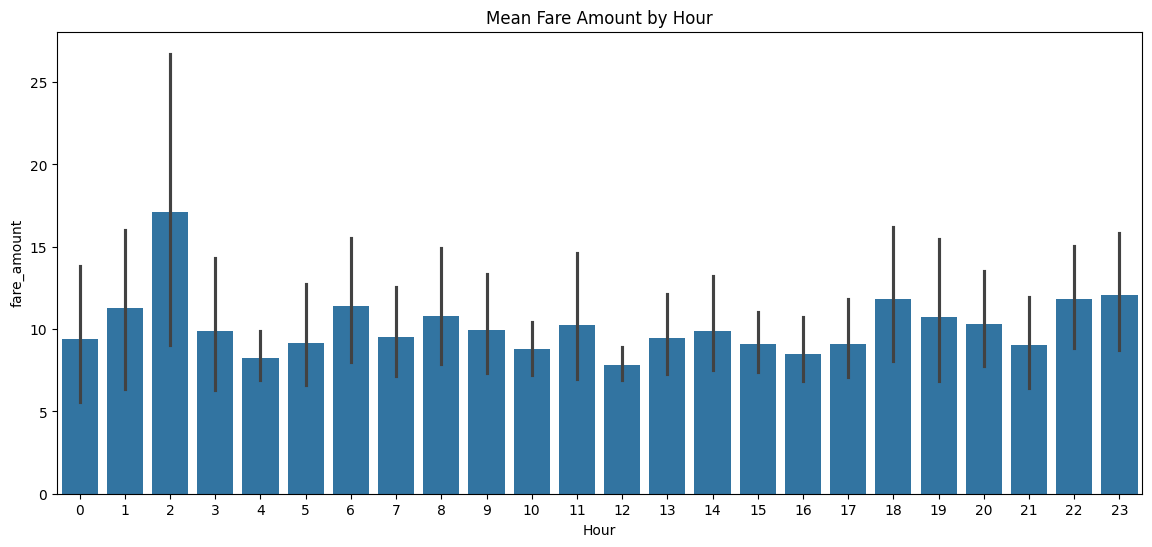

In [29]:
# Bar plot (mean fare amount)
plt.figure(figsize=(14, 6))
sns.barplot(x='Hour', y='fare_amount', data=test_df, estimator=np.mean)
plt.title('Mean Fare Amount by Hour')
plt.show()

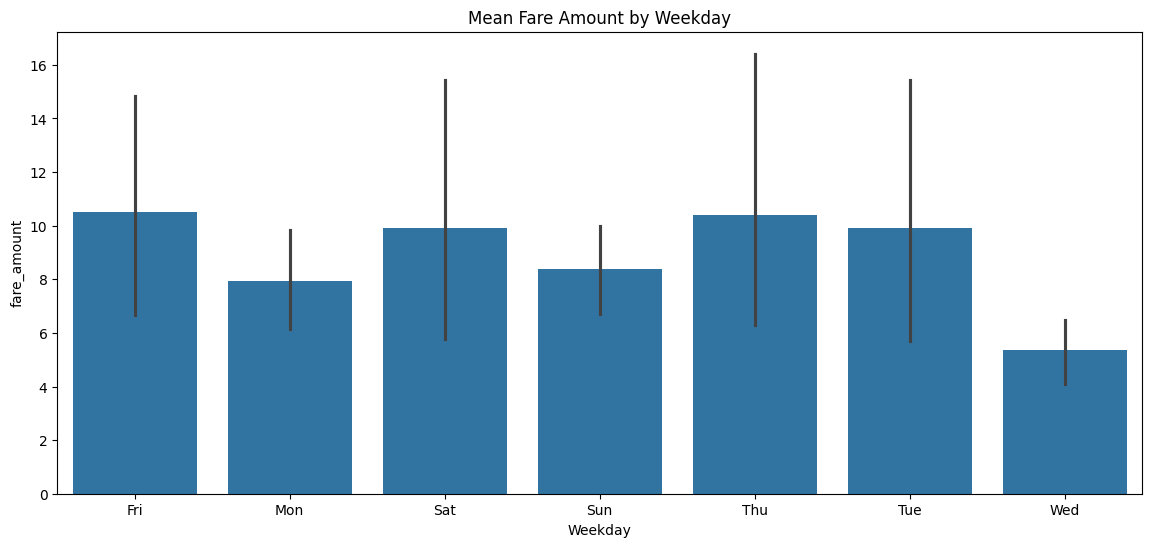

In [21]:
plt.figure(figsize=(14, 6))
sns.barplot(x='Weekday', y='fare_amount', data=test_df, estimator=np.mean)
plt.title('Mean Fare Amount by Weekday')
plt.show()